In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# para compatibilidad con la RTX 2080 super
# esto no es necesario para la RTX 2080 ti
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3

In [3]:
X = np.load('../InpactorDB/InpactorDB_v1.fasta.filtered.npy')
Y = np.load('../InpactorDB/InpactorDB_v1.fasta.filtered_lables.npy')

#X = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.clean.npy')
#Y = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.clean_lables.npy')

#X = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.filtered.npy')
#Y = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.filtered_lables.npy')


In [4]:
print(X.shape)
print(Y.shape)

(40390, 5, 24902)
(40390, 1)


In [5]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(32312, 5, 24902)
(32312, 1)
(4039, 5, 24902)
(4039, 1)
(4039, 5, 24902)
(4039, 1)


In [6]:
X = None
Y = None
path_log_base = './logs_CNN'

In [7]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [8]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [9]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,
                      validation_data=(X_valid, y_valid),
                      verbose=2)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def TERL():
    tf.keras.backend.clear_session()

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(inputs)
    layers = tf.keras.layers.AveragePooling2D((1, 10), strides= (1, 10))(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    #layers = tf.keras.layers.Dense(1000,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    #layers = tf.keras.layers.Dropout(0.05)(layers)
    #layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 24902, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 24883, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2488, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2469, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 164, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 130, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 8, 32)          0     

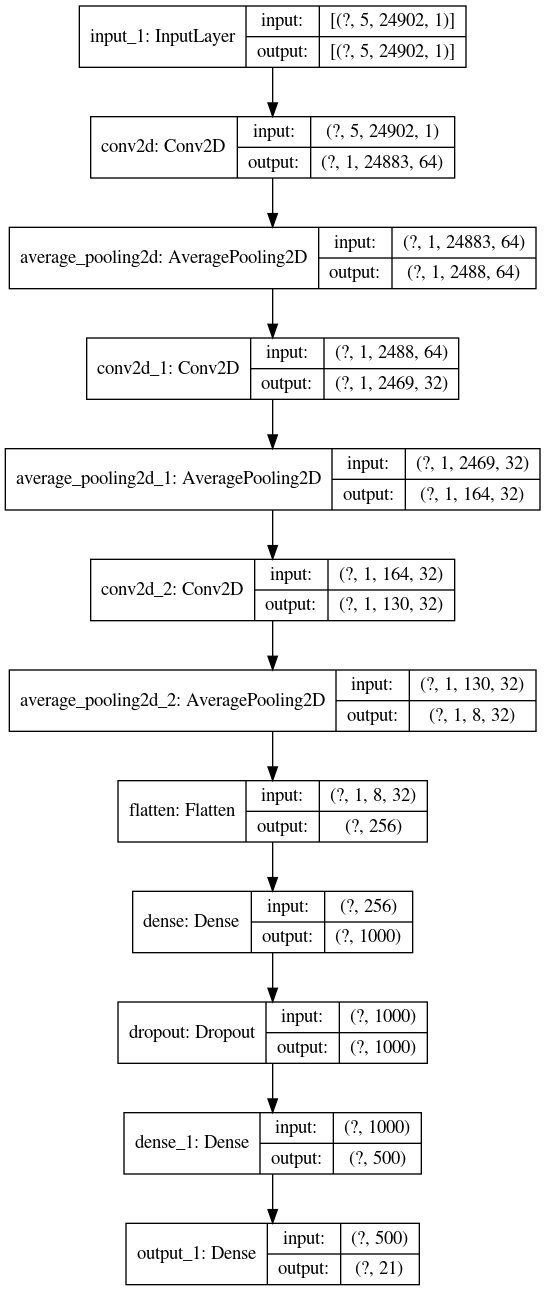

In [14]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
history = model.fit(X_train, one_hot_labels_train, epochs=epochs, 
                      batch_size=32,
                      validation_data=(X_dev, one_hot_labels_validation),
                      verbose=1)

#train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 256, epochs, "TERL")
#final_Results_Test(log_Dir)

Epoch 1/100
1010/1010 [==============================] - 20s 20ms/step - loss: 1.3512 - accuracy: 0.5480 - val_loss: 0.8792 - val_accuracy: 0.7046
Epoch 2/100
1010/1010 [==============================] - 19s 19ms/step - loss: 0.7606 - accuracy: 0.7430 - val_loss: 0.6355 - val_accuracy: 0.7891
Epoch 3/100
1010/1010 [==============================] - 19s 19ms/step - loss: 0.5863 - accuracy: 0.8020 - val_loss: 0.5082 - val_accuracy: 0.8255
Epoch 4/100
1010/1010 [==============================] - 20s 19ms/step - loss: 0.4690 - accuracy: 0.8439 - val_loss: 0.4864 - val_accuracy: 0.8373
Epoch 5/100
1010/1010 [==============================] - 20s 19ms/step - loss: 0.3844 - accuracy: 0.8729 - val_loss: 0.3639 - val_accuracy: 0.8824
Epoch 6/100
1010/1010 [==============================] - 19s 19ms/step - loss: 0.3220 - accuracy: 0.8921 - val_loss: 0.4293 - val_accuracy: 0.8680
Epoch 7/100
1010/1010 [==============================] - 20s 19ms/step - loss: 0.2752 - accuracy: 0.9096 - val_loss: 0

1010/1010 [==============================] - 19s 19ms/step - loss: 0.0320 - accuracy: 0.9905 - val_loss: 0.4063 - val_accuracy: 0.9403
Epoch 57/100
1010/1010 [==============================] - 19s 19ms/step - loss: 0.0444 - accuracy: 0.9873 - val_loss: 0.3499 - val_accuracy: 0.9379
Epoch 58/100
1010/1010 [==============================] - 19s 19ms/step - loss: 0.0237 - accuracy: 0.9928 - val_loss: 0.4285 - val_accuracy: 0.9371
Epoch 59/100
1010/1010 [==============================] - 20s 20ms/step - loss: 0.0315 - accuracy: 0.9906 - val_loss: 0.4571 - val_accuracy: 0.9284
Epoch 60/100
1010/1010 [==============================] - 20s 19ms/step - loss: 0.0315 - accuracy: 0.9907 - val_loss: 0.3739 - val_accuracy: 0.9354
Epoch 61/100
1010/1010 [==============================] - 20s 19ms/step - loss: 0.0283 - accuracy: 0.9915 - val_loss: 0.4072 - val_accuracy: 0.9381
Epoch 62/100
1010/1010 [==============================] - 19s 19ms/step - loss: 0.0342 - accuracy: 0.9906 - val_loss: 0.3840 

KeyboardInterrupt: 

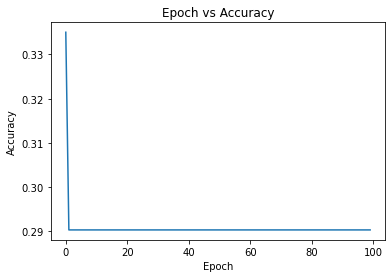

NameError: name 'AccTest' is not defined

In [16]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


Baseline Error train: 0.00%
Baseline Error dev: 9.15%
Baseline Error test: 6.32%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00    

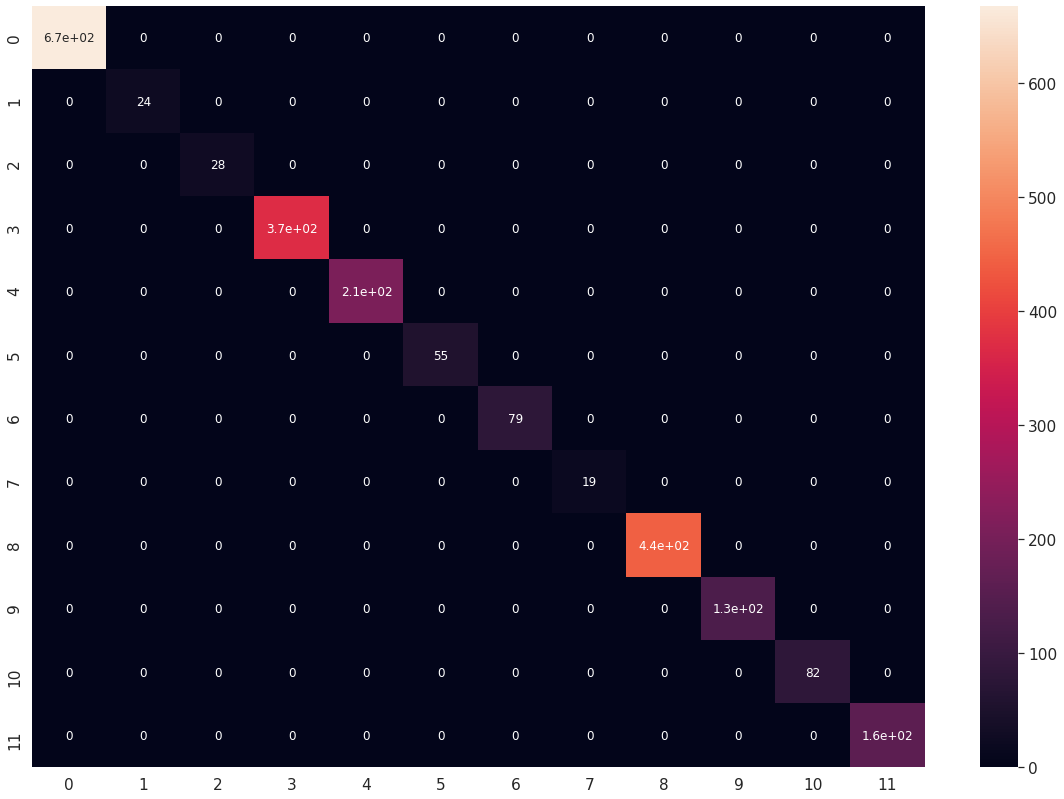

Accuracy: 0.9084507042253521
F1 score: 0.9077809720660045
Recall: 0.9084507042253521
Precision: 0.9097199563426799

 clasification report:
               precision    recall  f1-score   support

         1.0       0.97      0.98      0.97        88
         3.0       1.00      0.80      0.89         5
         4.0       0.86      0.86      0.86         7
         9.0       0.94      0.94      0.94        34
        12.0       0.94      0.85      0.89        34
        13.0       1.00      0.50      0.67         2
        14.0       0.75      0.82      0.78        11
        16.0       0.67      0.67      0.67         3
        17.0       0.90      0.96      0.93        48
        18.0       0.79      0.73      0.76        15
        19.0       0.88      0.88      0.88        17
        20.0       0.81      0.85      0.83        20

    accuracy                           0.91       284
   macro avg       0.87      0.82      0.84       284
weighted avg       0.91      0.91      0.91     

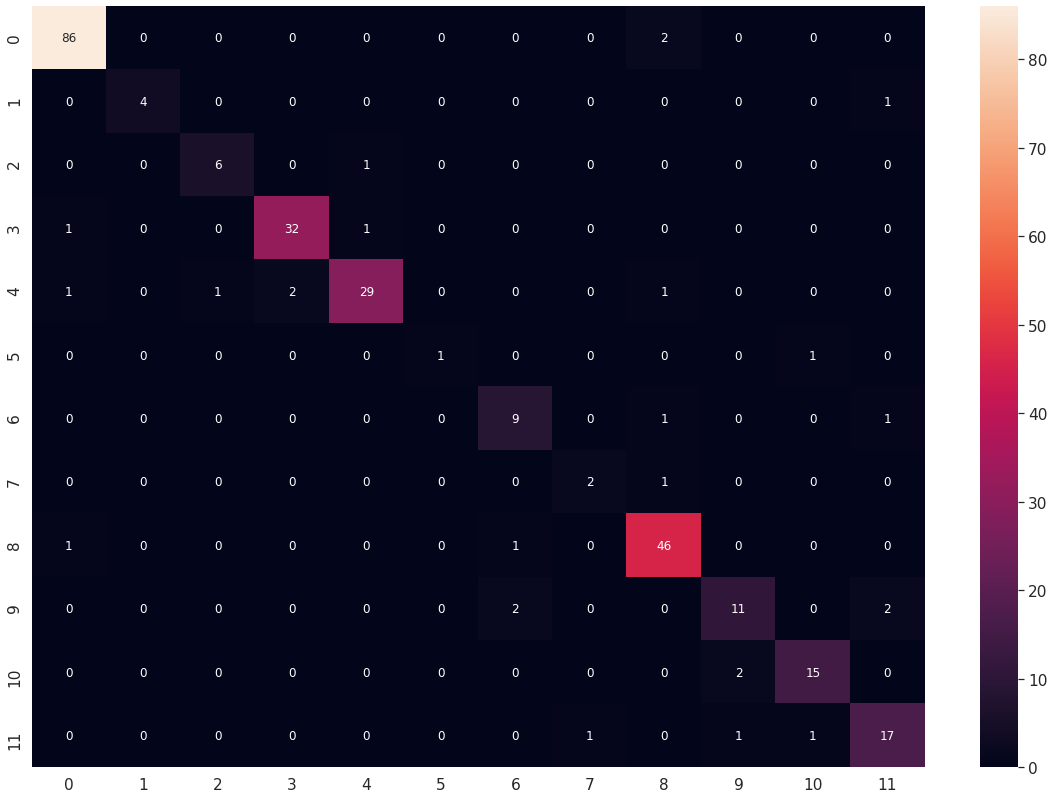

Accuracy: 0.9368421052631579
F1 score: 0.9374663609277645
Recall: 0.9368421052631579
Precision: 0.9438517554796626

 clasification report:
               precision    recall  f1-score   support

         1.0       0.99      0.97      0.98        79
         3.0       1.00      0.67      0.80         3
         4.0       1.00      1.00      1.00         1
         9.0       0.88      0.97      0.93        39
        12.0       0.97      0.86      0.91        37
        13.0       1.00      0.67      0.80         6
        14.0       1.00      0.91      0.95        11
        16.0       0.67      0.80      0.73         5
        17.0       1.00      1.00      1.00        60
        18.0       0.79      0.79      0.79        14
        19.0       0.67      1.00      0.80         8
        20.0       0.91      0.91      0.91        22

    accuracy                           0.94       285
   macro avg       0.91      0.88      0.88       285
weighted avg       0.94      0.94      0.94     

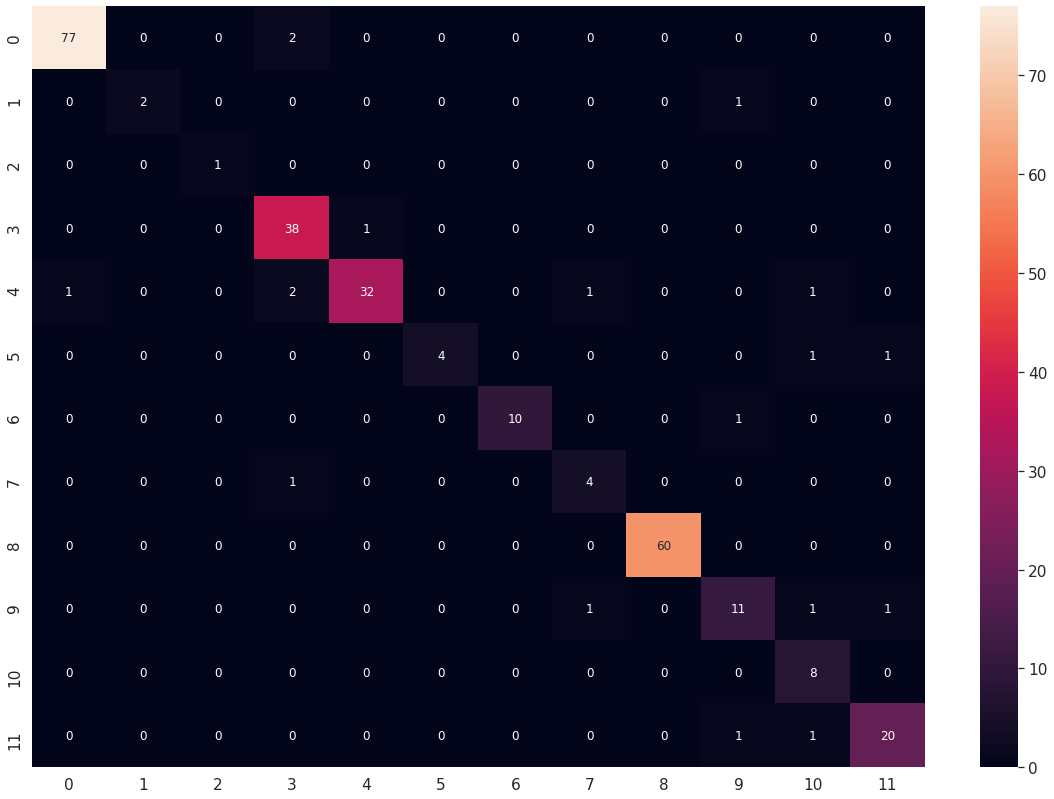

In [28]:
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])